In [55]:
import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [56]:
def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)

def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

def dual_control_sundials(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
    ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = repression(y[1], k1, theta1, n1) + activation(y[1], k2, theta2, n2)

def upstream_repression_sundials(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
    ydot[3] = k2 - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = repression(y[1], k1, theta1, n1) + k2

def downstream_activation_sundials(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = k1 - lam*y[2]
    ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = activation(y[1], k2, theta2, n2) + k1

def no_control(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = k1 - lam*y[2]
    ydot[3] = k2 - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = k1 + k2

def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss


In [57]:
space = [hp.uniform('k1', 1E-7, 1E-3), hp.uniform('k2', 1E-7, 1E-3), hp.uniform('theta1', 0.001, 10), hp.uniform('theta2', 0.001, 10)]

In [87]:
losses = []
params = []
def objective(param_values):
    #Integration conditions
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])

    #Set architecture
    ode_function = downstream_activation_sundials

    extra_options = {'old_api': False, 'user_data': param_values}
    ode_solver = ode('cvode', ode_function, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2)
    losses.append(loss)
    params.append(param_values)
    return loss

In [88]:
max_iters = [5000]
best_params = []
best_losses = []
for num_iters in max_iters:
    best = fmin(objective, space, algo=tpe.suggest, max_evals=num_iters)
    best_losses.append(objective(list(best.values())))
    best_params.append(best)

 28%|██▊       | 1386/5000 [00:30<01:18, 46.00trial/s, best loss: 0.061119134688284456]


KeyboardInterrupt: 

In [ ]:
landscape = pd.DataFrame({'loss': losses, 'k1': [params[i][0] for i in range(len(params))], 'k2': [params[i][1] for i in range(len(params))], 'theta1': [params[i][2] for i in range(len(params))], 'theta2': [params[i][3] for i in range(len(params))]})

In [ ]:
landscape.to_csv('test_landscape_5000_da.csv')

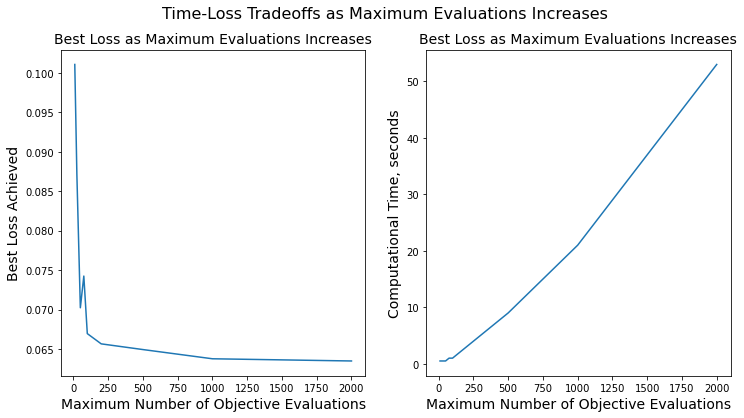

In [19]:
#Manually construct elapsed time figure
elapsed_times = [0.5, 0.5, 0.5, 1, 1, 3, 9, 21, 53]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
endpoint = 'Best Loss as Maximum Evaluations Increases'
ax = axs[0]
ax.plot(max_iters, best_losses)
ax.set_xlabel('Maximum Number of Objective Evaluations', fontsize=14)
ax.set_ylabel('Best Loss Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)

endpoint = 'Best Loss as Maximum Evaluations Increases'
ax = axs[1]
ax.plot(max_iters, elapsed_times)
ax.set_xlabel('Maximum Number of Objective Evaluations', fontsize=14)
ax.set_ylabel('Computational Time, seconds', fontsize=14)
ax.set_title(endpoint, fontsize=14)
fig.suptitle('Time-Loss Tradeoffs as Maximum Evaluations Increases', fontsize=16)
fig.savefig('max_evals_time_loss.png')

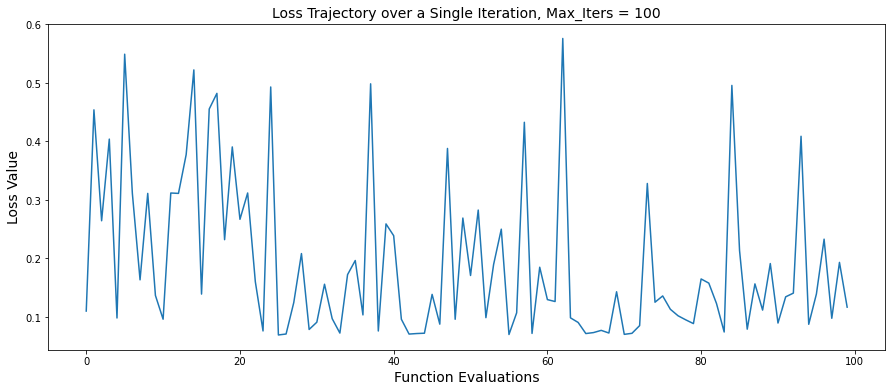

In [26]:
#Losses over a single iteration - shows it jumping around
#best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

fig, axs = plt.subplots(1, 1, figsize=(15, 6))
endpoint = 'Loss Trajectory over a Single Iteration, Max_Iters = 100'
ax = axs
ax.plot(losses)
ax.set_xlabel('Function Evaluations', fontsize=14)
ax.set_ylabel('Loss Value', fontsize=14)
ax.set_title(endpoint, fontsize=14)
fig.savefig('loss_over_iteration.png')

In [43]:
max_iters = [100, 200, 400, 800]
num_tries = 10

iters_list = []
best_params = []
best_losses = []
for num_iters in max_iters:
    for n in range(num_tries):
        best = fmin(objective, space, algo=tpe.suggest, max_evals=num_iters)
        best_losses.append(objective(list(best.values())))
        best_params.append(best)
        iters_list.append(num_iters)

100%|██████████| 800/800 [00:15<00:00, 53.02trial/s, best loss: 0.06980322491738242]


In [44]:
num_trials_data = pd.DataFrame({'num_iters': iters_list, 'best_losses': best_losses, 'best_params':best_params})
num_trials_data.to_csv('num_trials_data.csv')

In [45]:
num_trials_data = pd.read_csv('num_trials_data.csv')
k1s = []; k2s = []; theta1s = []; theta2s = []
for i in range(len(num_trials_data)):
    d = num_trials_data.best_params[i]
    k1s.append(float(d.split(',')[0].split(':')[-1]))
    k2s.append(float(d.split(',')[1].split(':')[-1]))
    theta1s.append(float(d.split(',')[2].split(':')[-1]))
    theta2s.append(float(d.split(',')[3].split(':')[-1].split('}')[0]))
num_trials_data['k1'] = k1s
num_trials_data['k2'] = k2s
num_trials_data['theta1'] = theta1s
num_trials_data['theta2'] = theta2s

In [46]:
num_trials_data.to_csv('ur_10trials.csv')

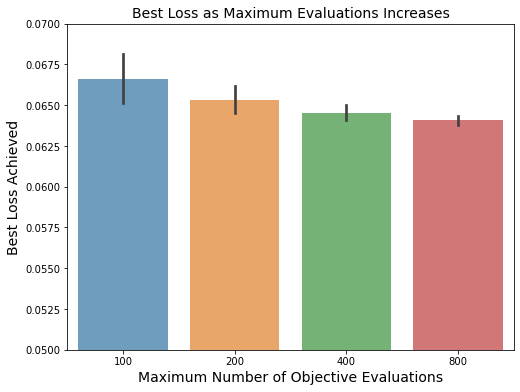

In [48]:
#num_trials_data = pd.read_csv('num_trials_data.csv')
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
endpoint = 'Best Loss as Maximum Evaluations Increases'
ax = axs
g = sns.barplot(
    data=num_trials_data,
    x="num_iters", y="best_losses", ci="sd", alpha=0.7)

ax.set_xlabel('Maximum Number of Objective Evaluations', fontsize=14)
ax.set_ylabel('Best Loss Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)
ax.set_ylim([0.05, 0.07])
fig.savefig('best_loss_bar_plot.png')

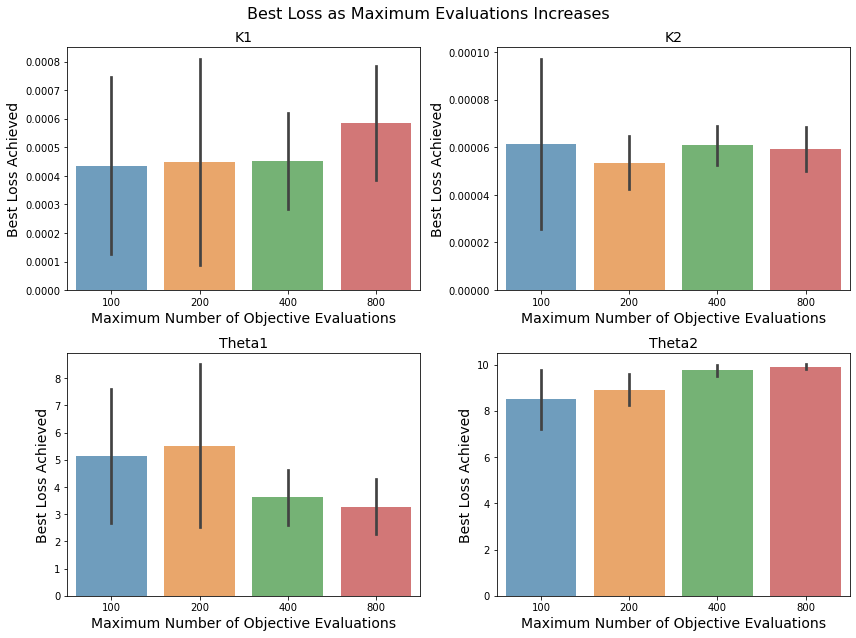

In [47]:

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
endpoint = 'K1'
ax = axs[0][0]
g = sns.barplot(
    data=num_trials_data,
    x="num_iters", y="k1", ci="sd", alpha=0.7, ax=ax)

ax.set_xlabel('Maximum Number of Objective Evaluations', fontsize=14)
ax.set_ylabel('Best Loss Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)

endpoint = 'K2'
ax = axs[0][1]
g = sns.barplot(
    data=num_trials_data,
    x="num_iters", y="k2", ci="sd", alpha=0.7, ax=ax)

ax.set_xlabel('Maximum Number of Objective Evaluations', fontsize=14)
ax.set_ylabel('Best Loss Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)

endpoint = 'Theta1'
ax = axs[1][0]
g = sns.barplot(
    data=num_trials_data,
    x="num_iters", y="theta1", ci="sd", alpha=0.7, ax=ax)

ax.set_xlabel('Maximum Number of Objective Evaluations', fontsize=14)
ax.set_ylabel('Best Loss Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)

endpoint = 'Theta2'
ax = axs[1][1]
g = sns.barplot(
    data=num_trials_data,
    x="num_iters", y="theta2", ci="sd", alpha=0.7, ax=ax)

ax.set_xlabel('Maximum Number of Objective Evaluations', fontsize=14)
ax.set_ylabel('Best Loss Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)
fig.suptitle('Best Loss as Maximum Evaluations Increases', fontsize=16)
fig.tight_layout()
fig.savefig('parameters_max_evals_bar.png')

In [53]:
#Run TSNE, PCA on multiple circuits
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

da = pd.read_csv('da_10trials.csv')
da['circuit'] = 'Downstream Activation'
ur = pd.read_csv('ur_10trials.csv')
ur['circuit'] = 'Upstream Repression'
nc = pd.read_csv('nc_10trials.csv')
nc['circuit'] = 'No Control'
dc = pd.read_csv('dc_10trials.csv')
dc['circuit'] = 'Dual Control'
combined = pd.concat([da, ur, nc, dc])
combined = combined.loc[combined.num_iters > 150]
features = ['k1', 'k2', 'theta1', 'theta2', 'best_losses']

x = combined.loc[:, features].values

#Normalize features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
combined['pc1'] = principalComponents[:,0]
combined['pc2'] = principalComponents[:,1]


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x)
combined['tsne1'] = tsne_results[:,0]
combined['tsne2'] = tsne_results[:,1]



[t-SNE] Computing 119 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.496736
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.202072
[t-SNE] KL divergence after 300 iterations: 0.207024


C:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


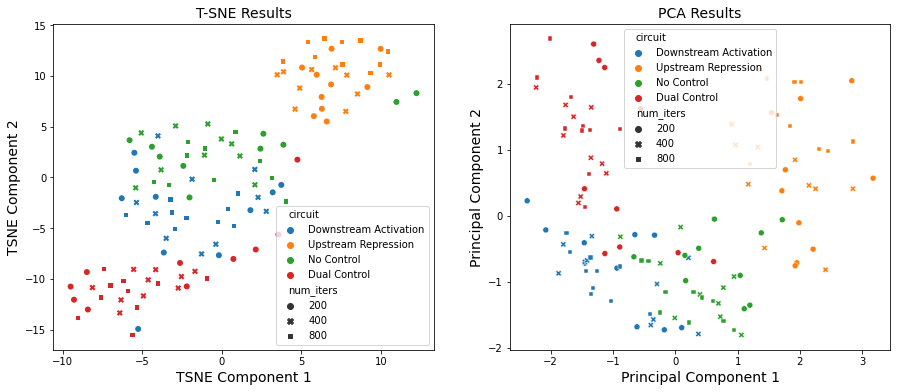

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

endpoint = 'T-SNE Results'
ax = axs[0]
#sns.scatterplot(x='pc1', y='pc2', data = finalDf, hue='loss', ax=ax)
sns.scatterplot(x="tsne1", y="tsne2",
                hue="circuit", style='num_iters',
                sizes=(1, 8), linewidth=0,
                data=combined, ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)


endpoint = 'PCA Results'
ax = axs[1]
sns.scatterplot(x='pc1', y='pc2', data = combined, hue='circuit', style='num_iters', ax=ax)

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
fig.savefig('TSNE_PCA_hyperopt_trials.png')